# Information Leakage
Information leakage dapat menyebabkan hasil pengukuran performa pada validation set atau test set menjadi bias. Hasil pengukuran performa menjadi tidak sebaik kenyataan.


In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge

In [2]:
#data dummy yg dirandomize
rnd= np.random.RandomState(seed=2020)
x= rnd.normal(size=(100,10000))
y=rnd.normal(size=(100,))

Seharusnya x dan y tidak memiliki hubungan karena dibuat secara random

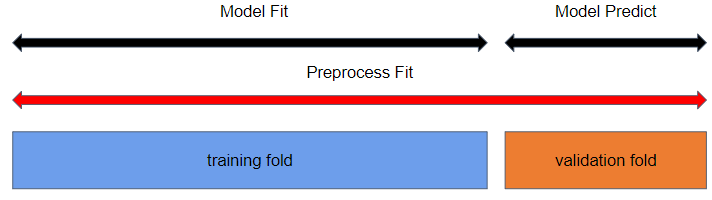

In [3]:
## cara preprocessing yang salah

In [4]:
from sklearn.feature_selection import SelectPercentile, f_regression

In [5]:
select= SelectPercentile(score_func=f_regression, percentile= 5).fit(x,y)
x_selected=select.transform(x)
x_selected.shape

(100, 500)

In [6]:
pd.DataFrame({
    '1':x_selected[:,0],
    '2':x_selected[:,1],
    '3':x_selected[:,2],
    '4':x_selected[:,3],
    '5':x_selected[:,4],
    'y':y
}).corr() #korelasi rendah antara x dan y

,1,2,3,4,5,y
1,1.000000,0.142196,-0.245227,-0.109790,-0.007893,0.206695
2,0.142196,1.000000,-0.054322,-0.004183,-0.024308,0.276550
3,-0.245227,-0.054322,1.000000,-0.183848,0.138955,-0.211394
4,-0.109790,-0.004183,-0.183848,1.000000,0.110494,-0.227189
5,-0.007893,-0.024308,0.138955,0.110494,1.000000,-0.241444
y,0.206695,0.276550,-0.211394,-0.227189,-0.241444,1.000000


In [7]:
cross_val_score(Ridge(),x_selected,y,cv=5)

array([0.92165345, 0.89445668, 0.92827414, 0.93088559, 0.91044624])

hasil cross validasi mengindikasikan model dengan perdiksi sangat baik, walaupun data yang dipakai acak dan seharusnya tidak ada hubungan antara x dan y. Ini disebabkan oleh information leakage karena proses preprosessing yang kurang tepat.

In [8]:
# preprocessing dengan pipeline

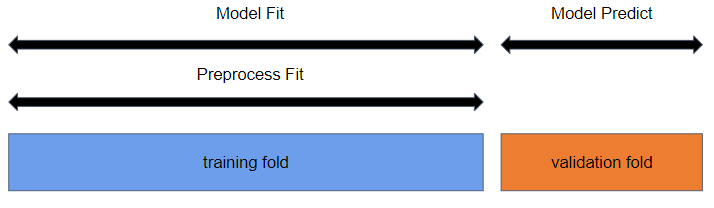

In [9]:
from sklearn.pipeline import Pipeline

In [10]:
select= SelectPercentile(score_func=f_regression, percentile=5)

pipe=Pipeline([
    ('select',select),
    ('ridge',Ridge())
])

In [11]:
cross_val_score(pipe,x,y,cv=5)

array([-0.0330359 , -0.07840338, -0.06731106, -0.04544685, -0.07314928])

ini adalah nilai r-squared yang seharusnya kita dapatkan, sangat rendah, bahkan negatif.

# Algorithm Chain: Adult Dataset

In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import classification_report

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import category_encoders as ce
from sklearn.pipeline import Pipeline

# Data

In [13]:
df=pd.read_csv('adult.csv')
df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [14]:
df.replace('?',np.nan).isna().sum()
#missing value pada kolom workclass, occupation, native.country

age                  0
workclass         1836
fnlwgt               0
education            0
education.num        0
marital.status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital.gain         0
capital.loss         0
hours.per.week       0
native.country     583
income               0
dtype: int64

## Preprocessing
y= income  
x= drop fnlwgt  

skema=  
* one hot: relationship, race, sex  
* simple imputer (constan),binary: workclass, marital.status, occupation, native.country
* ordinal: education (sudah dibuat)

In [15]:
binary_pipe=Pipeline([
    ('imputer', SimpleImputer(strategy='constant',fill_value='NC',missing_values='?')),
    ('binary', ce.BinaryEncoder(drop_invariant=True))
])

In [16]:
transformer=ColumnTransformer([
    ('onehot',OneHotEncoder(drop='first'),['relationship','race','sex']),
    ('binary', binary_pipe,['workclass','marital.status','occupation','native.country'])
], remainder='passthrough')

In [17]:
transformer.fit_transform(df) #coba jalan atau tidak

array([[1.0, 0.0, 0.0, ..., 4356, 40, '<=50K'],
       [1.0, 0.0, 0.0, ..., 4356, 18, '<=50K'],
       [0.0, 0.0, 0.0, ..., 4356, 40, '<=50K'],
       ...,
       [0.0, 0.0, 0.0, ..., 0, 40, '>50K'],
       [0.0, 0.0, 0.0, ..., 0, 40, '<=50K'],
       [0.0, 0.0, 1.0, ..., 0, 20, '<=50K']], dtype=object)

## Splitting Data

In [18]:
x=df.drop(columns=['fnlwgt','education','income'])
y=np.where(df['income']=='>50K',1,0)

In [19]:
pd.Series(y).value_counts()

0    24720
1     7841
dtype: int64

In [20]:
x_train,x_test, y_train, y_test= train_test_split(x,y, stratify=y, random_state=2020)

## Benchmark

In [21]:
tree= DecisionTreeClassifier(criterion='entropy',max_depth=5, random_state=2020)
pipe_tree=Pipeline([
    ('preprocess',transformer),
    ('model',tree)
])

In [22]:
skfold= StratifiedKFold(n_splits=5)
model_cv= cross_val_score(pipe_tree, x_train,y_train, scoring='f1',cv=5)

In [23]:
print(model_cv)
print(model_cv.mean())
print(model_cv.std())

[0.59255482 0.60502513 0.59898477 0.62110553 0.6221336 ]
0.6079607686024484
0.011833711368265581


In [24]:
tree=DecisionTreeClassifier(criterion='entropy',max_depth=5,random_state=2020)
logreg=LogisticRegression(solver='liblinear',random_state=2020)

In [25]:
models=[tree,logreg]
score=[]
rata=[]
std=[]

for i in models:
    skfold= StratifiedKFold(n_splits=5)
    estimator=Pipeline([
        ('preprocessing',transformer),
        ('model',i)
    ])
    model_cv=cross_val_score(estimator,x_train,y_train,cv=skfold,scoring='f1')
    score.append(model_cv)
    rata.append(model_cv.mean())
    std.append(model_cv.std())

In [26]:
pd.DataFrame({
    'model':['tree','logreg'],
    'mean':rata,
    'std':std
})

,model,mean,std
0,tree,0.607961,0.011834
1,logreg,0.640677,0.019889


Dari hasil cross validasi logreg memiliki performa yang lebih baik dari tree, walaupun sedikit lebih tidak stabil. Kita bisa memilih logreg sebagai benchmark untuk kita tunning

## Model Performance with Data test

In [27]:
logreg=LogisticRegression(solver='liblinear',random_state=2020)
estimator=Pipeline([
    ('preprocess',transformer),
    ('model',logreg)
])
estimator.fit(x_train,y_train)
y_pred= estimator.predict(x_test)

In [28]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.88      0.93      0.90      6181
           1       0.73      0.59      0.65      1960

    accuracy                           0.85      8141
   macro avg       0.81      0.76      0.78      8141
weighted avg       0.84      0.85      0.84      8141



In [29]:
estimator[1].coef_ #kalau mau lihat coef

array([[-2.06589834e+00, -1.76471928e+00, -3.13567118e+00,
        -2.30105668e+00,  1.08329068e+00, -1.09515282e+00,
        -1.01960391e+00, -6.96146915e-01, -6.43503713e-01,
         6.59873480e-01, -9.68860828e-02,  1.74453234e-01,
         1.47669680e-01,  6.50665129e-01,  2.29407753e-01,
        -6.21373988e-02, -4.84530889e-01, -5.95146901e-01,
         4.51870566e-02, -4.71731669e-01,  4.92313898e-02,
        -8.07250364e-01, -5.03459574e-01, -7.54969842e-01,
        -1.37268704e-01, -8.42264114e-01,  1.68612364e-02,
         2.30843888e-02,  3.06069765e-01,  3.09048541e-04,
         6.36368710e-04,  2.57747471e-02]])

In [30]:
estimator[0].transformers_[0][1].get_feature_names_out()

array(['relationship_Not-in-family', 'relationship_Other-relative',
       'relationship_Own-child', 'relationship_Unmarried',
       'relationship_Wife', 'race_Asian-Pac-Islander', 'race_Black',
       'race_Other', 'race_White', 'sex_Male'], dtype=object)

In [31]:
estimator[0].transformers_[1][1][1].get_feature_names()

['0_1',
 '0_2',
 '0_3',
 '0_4',
 '1_1',
 '1_2',
 '1_3',
 '2_1',
 '2_2',
 '2_3',
 '2_4',
 '3_1',
 '3_2',
 '3_3',
 '3_4',
 '3_5',
 '3_6']

In [32]:
estimator[0].transformers_

[('onehot', OneHotEncoder(drop='first'), ['relationship', 'race', 'sex']),
 ('binary',
  Pipeline(steps=[('imputer',
                   SimpleImputer(fill_value='NC', missing_values='?',
                                 strategy='constant')),
                  ('binary', BinaryEncoder(drop_invariant=True))]),
  ['workclass', 'marital.status', 'occupation', 'native.country']),
 ('remainder', 'passthrough', [0, 2, 8, 9, 10])]

In [33]:
list(x.iloc[:,[0, 2, 8, 9, 10]].columns)

['age', 'education.num', 'capital.gain', 'capital.loss', 'hours.per.week']

In [34]:
feature=list(estimator[0].transformers_[0][1].get_feature_names_out())+estimator[0].transformers_[1][1][1].get_feature_names()+list(x.iloc[:,[0, 2, 8, 9, 10]].columns)

In [35]:
len(feature)

32

In [36]:
pd.DataFrame({'coef':estimator[1].coef_.flatten()}, index=feature)

,coef
relationship_Not-in-family,-2.065898
relationship_Other-relative,-1.764719
relationship_Own-child,-3.135671
relationship_Unmarried,-2.301057
relationship_Wife,1.083291
race_Asian-Pac-Islander,-1.095153
race_Black,-1.019604
race_Other,-0.696147
race_White,-0.643504
sex_Male,0.659873


## Hyperparameter Tunning

In [37]:
logreg= LogisticRegression(solver='liblinear',random_state=2020)
estimator=Pipeline([
    ('preprocess',transformer),
    ('model',logreg)
])

In [38]:
estimator.get_params()

{'memory': None,
 'steps': [('preprocess',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('onehot', OneHotEncoder(drop='first'),
                                    ['relationship', 'race', 'sex']),
                                   ('binary',
                                    Pipeline(steps=[('imputer',
                                                     SimpleImputer(fill_value='NC',
                                                                   missing_values='?',
                                                                   strategy='constant')),
                                                    ('binary',
                                                     BinaryEncoder(drop_invariant=True))]),
                                    ['workclass', 'marital.status', 'occupation',
                                     'native.country'])])),
  ('model', LogisticRegression(random_state=2020, solver='liblinear'))],
 'verbose': False,
 'prep

In [39]:
hyperparam_space={
    'model__C':[100,10,1,0.1,0.001],
    'model__solver':['liblinear','newton-cg']
}

In [40]:
skfold=StratifiedKFold(n_splits=5)
grid_search=GridSearchCV(
    estimator,
    param_grid=hyperparam_space,
    cv=skfold,
    scoring='f1',
    n_jobs=-1
)

In [41]:
grid_search.fit(x_train,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehot',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['relationship',
                                                                          'race',
                                                                          'sex']),
                                                                        ('binary',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(fill_value='NC',
                                       

In [42]:
print(grid_search.best_score_)
print(grid_search.best_params_)

0.6460237640462658
{'model__C': 100, 'model__solver': 'newton-cg'}


In [43]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__C,param_model__solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.970162,0.279224,0.099933,0.024021,100,liblinear,"{'model__C': 100, 'model__solver': 'liblinear'}",0.606654,0.661025,0.632089,0.640535,0.655238,0.639108,0.019210,7
1,22.275088,3.898713,0.096945,0.015023,100,newton-cg,"{'model__C': 100, 'model__solver': 'newton-cg'}",0.625773,0.665730,0.628846,0.642790,0.666980,0.646024,0.017568,1
2,2.312854,0.458987,0.114893,0.028667,10,liblinear,"{'model__C': 10, 'model__solver': 'liblinear'}",0.606654,0.660714,0.634264,0.640842,0.665728,0.641640,0.021086,5
3,15.716847,1.796297,0.109706,0.040256,10,newton-cg,"{'model__C': 10, 'model__solver': 'newton-cg'}",0.625119,0.665730,0.628846,0.643093,0.666980,0.645954,0.017710,2
4,2.754455,0.213189,0.107313,0.009326,1,liblinear,"{'model__C': 1, 'model__solver': 'liblinear'}",0.606565,0.660714,0.633317,0.643363,0.659424,0.640677,0.019889,6
5,11.422483,0.811401,0.093954,0.012309,1,newton-cg,"{'model__C': 1, 'model__solver': 'newton-cg'}",0.624762,0.664477,0.627526,0.642756,0.666353,0.645175,0.017636,3
6,2.129018,0.159767,0.093151,0.011081,0.1,liblinear,"{'model__C': 0.1, 'model__solver': 'liblinear'}",0.601779,0.633171,0.621100,0.636711,0.644380,0.627428,0.014862,8
7,8.279607,0.275136,0.076787,0.022832,0.1,newton-cg,"{'model__C': 0.1, 'model__solver': 'newton-cg'}",0.622778,0.661633,0.623188,0.644550,0.664775,0.643385,0.018025,4
8,1.839515,0.139516,0.098138,0.007480,0.001,liblinear,"{'model__C': 0.001, 'model__solver': 'liblinear'}",0.431373,0.448276,0.392405,0.431108,0.439601,0.428553,0.019143,10
9,4.723889,0.304718,0.034525,0.007334,0.001,newton-cg,"{'model__C': 0.001, 'model__solver': 'newton-cg'}",0.557794,0.559358,0.536559,0.569910,0.572038,0.559132,0.012603,9


## Before vs After Tunning

In [44]:
logreg= LogisticRegression(solver='liblinear', random_state=2020)
estimator= Pipeline([
    ('preprocess',transformer),
    ('model',logreg)
])
estimator.fit(x_train,y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(drop='first'),
                                                  ['relationship', 'race',
                                                   'sex']),
                                                 ('binary',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='NC',
                                                                                 missing_values='?',
                                                                                 strategy='constant')),
                                                                  ('binary',
                                                                   BinaryEncoder(drop_invariant=True))]),
           

In [45]:
y_pred=estimator.predict(x_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.88      0.93      0.90      6181
           1       0.73      0.59      0.65      1960

    accuracy                           0.85      8141
   macro avg       0.81      0.76      0.78      8141
weighted avg       0.84      0.85      0.84      8141



In [46]:
from sklearn.metrics import f1_score
f1_score(y_test,y_pred)

0.6521246458923512

In [47]:
# after
best_model=grid_search.best_estimator_
best_model.fit(x_train,y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(drop='first'),
                                                  ['relationship', 'race',
                                                   'sex']),
                                                 ('binary',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='NC',
                                                                                 missing_values='?',
                                                                                 strategy='constant')),
                                                                  ('binary',
                                                                   BinaryEncoder(drop_invariant=True))]),
           

In [48]:
y_pred=best_model.predict(x_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.88      0.93      0.90      6181
           1       0.73      0.60      0.66      1960

    accuracy                           0.85      8141
   macro avg       0.80      0.76      0.78      8141
weighted avg       0.84      0.85      0.84      8141



In [49]:
f1_score(y_test,y_pred)

0.6567749160134378

Performa model naik sedikit, dengan presisi dari 65.3% menjadi 65.7%

### Model Atributte after tunning

In [50]:
pd.DataFrame({'coef':best_model[1].coef_.flatten()},index=feature)

,coef
relationship_Not-in-family,-1.580381
relationship_Other-relative,-1.684430
relationship_Own-child,-2.748223
relationship_Unmarried,-1.774852
relationship_Wife,1.343653
race_Asian-Pac-Islander,0.803037
race_Black,0.520847
race_Other,0.092180
race_White,0.777806
sex_Male,0.792385


# latihan
Dengan menggunakan data titanic:  
* x= *sex*, age, fare, *class*, *embark_town*, *alone*  
* y= survived
* test size 0.2
* random state 2020


Dan skema preprocesing berikut:
* simple imputer most frequent: embark town
* simple imputer median: age
* onehot: sex, embark town, alone  
* ordinal: class
* untuk logreg saja: fare, age: robust scaling  


pilih model terbaik di antara model berikut dengan metrik evaluasi yang menurut kalian paling sesuai:
    * logistic regression
    * decision tree classifier (max depth =3)

Tampilkan atribut dari model yang terpilih (feature importance/coeficient)  
    
**Gunakan pipeline** untuk menghindari information leakage!

In [51]:
import seaborn as sns
titanic=sns.load_dataset('titanic')
x=titanic[['sex','age','fare','class','embark_town', 'alone']]
y=titanic['survived']
x_train,x_test,y_train,y_test= train_test_split(x,y,test_size=0.2, stratify=y, random_state=2020)

In [52]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder,RobustScaler
from sklearn.impute import SimpleImputer
import category_encoders as ce

In [53]:
# Transformer
pipe_onehot= Pipeline([
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('onehot', ce.OneHotEncoder(drop_invariant=True))
])
ordinal_mapping = [
    {'col':'class',
    'mapping':{None:0,'First':1,'Second':2,'Third':3}}
    ]

transformer1=ColumnTransformer([
    ('onehot',pipe_onehot,['sex', 'embark_town', 'alone']),
    ('ordinal',ce.OrdinalEncoder(mapping = ordinal_mapping),['class']),
    ('impute', SimpleImputer(strategy='median'),['age'])
], remainder='passthrough')

In [54]:
pipe_scaling= Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('scale', RobustScaler())])
    
transformer2=ColumnTransformer([
    ('onehot',pipe_onehot,['sex', 'embark_town', 'alone']),
    ('ordinal',ce.OrdinalEncoder(mapping = ordinal_mapping),['class']),
    ('scaling', pipe_scaling,['age','fare'])
], remainder='passthrough')

In [55]:
logreg=LogisticRegression(max_iter=1000,random_state=2020)
tree=DecisionTreeClassifier(max_depth=3, random_state=2020)

pipe_logreg=Pipeline([
    ('transform',transformer2),
    ('model', logreg)
])

pipe_tree=Pipeline([
    ('transform',transformer1),
    ('model', tree)
])

In [56]:
models=[pipe_logreg,pipe_tree]
score=[]
rata=[]
std=[]

for i in models:
    skfold= StratifiedKFold(n_splits=5)

    model_cv=cross_val_score(i,x_train,y_train,cv=skfold,scoring='precision')
    score.append(model_cv)
    rata.append(model_cv.mean())
    std.append(model_cv.std())

In [57]:
pd.DataFrame({
    'model':['logreg','tree'],
    'mean':rata,
    'std':std
})

,model,mean,std
0,logreg,0.746070,0.066982
1,tree,0.793665,0.039396


In [58]:
# pilih tree karena rata-rata lebih tinggi dan lebih stabil
#performa di data test
pipe_tree.fit(x_train,y_train)
y_pred=pipe_tree.predict(x_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.80      0.85      0.82       110
           1       0.73      0.67      0.70        69

    accuracy                           0.78       179
   macro avg       0.77      0.76      0.76       179
weighted avg       0.77      0.78      0.77       179



In [59]:
#koef
pipe_tree[0].transformers_

[('onehot',
  Pipeline(steps=[('impute', SimpleImputer(strategy='most_frequent')),
                  ('onehot', OneHotEncoder(cols=[0, 1, 2], drop_invariant=True))]),
  ['sex', 'embark_town', 'alone']),
 ('ordinal',
  OrdinalEncoder(cols=['class'],
                 mapping=[{'col': 'class',
                           'mapping': {None: 0, 'First': 1, 'Second': 2,
                                       'Third': 3}}]),
  ['class']),
 ('impute', SimpleImputer(strategy='median'), ['age']),
 ('remainder', 'passthrough', [2])]

In [60]:
feature=list(pipe_tree[0].transformers_[0][1][1].get_feature_names())+['class','age','fare']

In [61]:
pd.DataFrame({'importance':pipe_tree[1].feature_importances_},index=feature)

,importance
0_1,0.000000
0_2,0.628704
1_1,0.000000
1_2,0.000000
1_3,0.000000
2_1,0.000000
2_2,0.000000
class,0.172485
age,0.064861
fare,0.133950


# latihan 2
Dengan menggunakan data titanic:  
* x= *sex*, age, fare, *class*, *embark_town*, *alone*  
* y= survived
* test size 0.2
* random state 2020


Dan skema preprocesing berikut:
* simple imputer most frequent: embark town
* simple imputer median: age
* onehot: sex, embark town, alone  
* ordinal: class



Coba lakukan tunning pada model yang sudah terpilih di latihan sebelumnya. Cari model dengan precision setinggi mungkin.
    * decision tree classifier (max depth =3)

Tampilkan atribut dari model yang terpilih (feature importance)  
    
**Gunakan pipeline** untuk menghindari information leakage!

In [62]:
pipe_tree=Pipeline([
    ('transform',transformer1),
    ('model', tree)
])

In [63]:
hyperparam_space={
    'model__max_depth':[1,2,3,4,5],
    'model__min_samples_split':[2,5,10,15,25,50,75,85,100,200,300],
    'model__min_samples_leaf':[1,2,5,10,15,25,50,75,100,200,300],
    'model__criterion':['entropy','gini']
}

In [66]:
skfold= StratifiedKFold(n_splits=5)
grid_search= GridSearchCV(
    pipe_tree, 
    param_grid=hyperparam_space, 
    cv=skfold,
    scoring='precision',
    n_jobs= -1 
)

In [67]:
grid_search.fit(x_train,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('transform',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehot',
                                                                         Pipeline(steps=[('impute',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(drop_invariant=True))]),
                                                                         ['sex',
                                                                          'embark_town',
                                                                       

In [68]:
grid_search.best_params_,grid_search.best_score_ 

({'model__criterion': 'entropy',
  'model__max_depth': 2,
  'model__min_samples_leaf': 50,
  'model__min_samples_split': 2},
 0.9038993505611261)

In [69]:
pipe_tree.fit(x_train,y_train)
y_pred=pipe_tree.predict(x_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.80      0.85      0.82       110
           1       0.73      0.67      0.70        69

    accuracy                           0.78       179
   macro avg       0.77      0.76      0.76       179
weighted avg       0.77      0.78      0.77       179



In [70]:
tree= grid_search.best_estimator_
tree.fit(x_train,y_train)
print(classification_report(y_test,tree.predict(x_test)))

              precision    recall  f1-score   support

           0       0.71      0.98      0.82       110
           1       0.92      0.35      0.51        69

    accuracy                           0.74       179
   macro avg       0.81      0.66      0.66       179
weighted avg       0.79      0.74      0.70       179



In [76]:
feature=list(tree[0].transformers_[0][1][1].get_feature_names())+['class','age','fare']

In [75]:
 pd.DataFrame({'importance':tree[1].feature_importances_}, index=feature)

,importance
0_1,0.000000
0_2,0.678670
1_1,0.000000
1_2,0.000000
1_3,0.000000
2_1,0.000000
2_2,0.000000
class,0.243918
age,0.000000
fare,0.077412
